Found 6563 validated image filenames belonging to 38 classes.
Found 2188 validated image filenames belonging to 38 classes.
Found 10547 validated image filenames belonging to 38 classes.
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 2511s 12s/step - accuracy: 0.2278 - loss: 6.6440 - val_accuracy: 0.4580 - val_loss: 2.0867
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2372s 12s/step - accuracy: 0.5780 - loss: 2.0707 - val_accuracy: 0.7655 - val_loss: 0.8667
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2357s 11s/step - accuracy: 0.7091 - loss: 1.2494 - val_accuracy: 0.0242 - val_loss: 6.4619
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2358s 11s/step - accuracy: 0.8038 - loss: 0.6946 - val_accuracy: 0.6572 - val_loss: 1.2300
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 2359s 11s/step - accuracy: 0.8522 - loss: 0.5010 - val_accuracy: 0.8464 - val_loss: 0.5073
330/330 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.8025 - loss: 0.6896
Final Test Accuracy: 0.8286716341972351


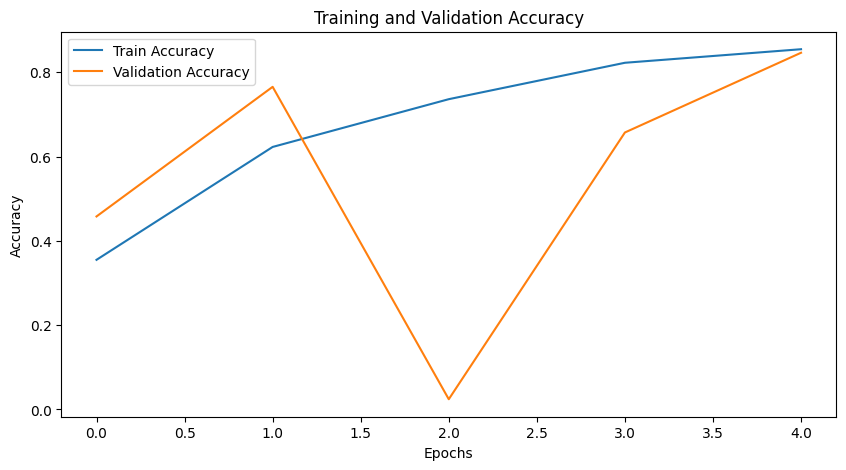

330/330 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step


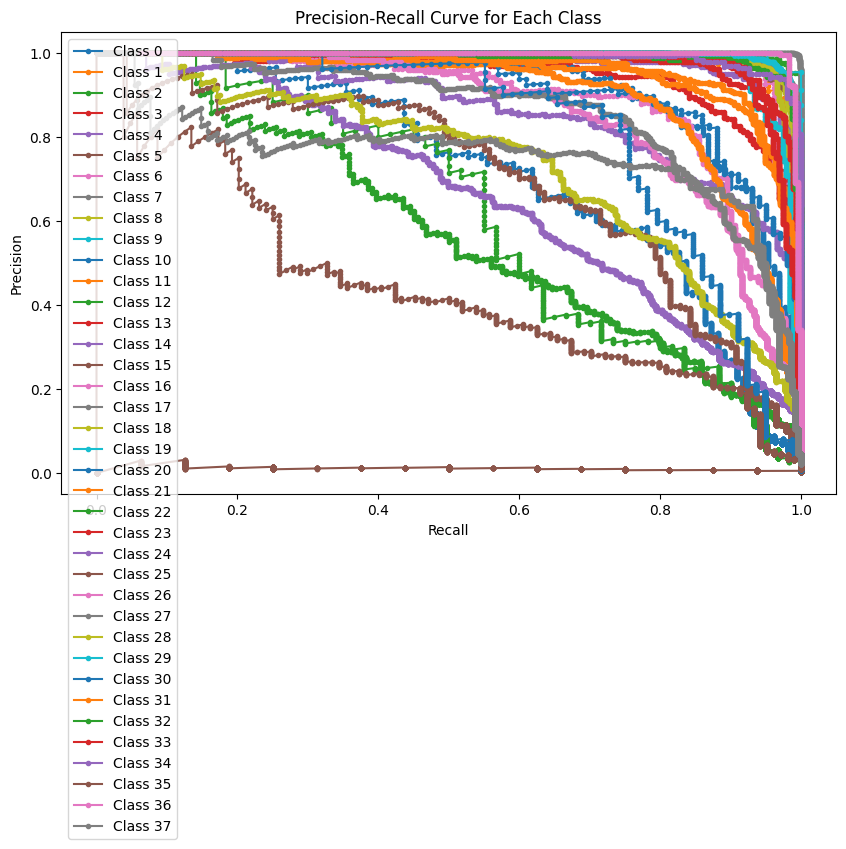

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Set dataset paths
dataset_path = "/kaggle/input/plantvillage-dataset/data_distribution_for_SVM"

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {str(i): i for i in range(38)}

# Collect images and labels from the train folder
train_folder = os.path.join(dataset_path, "train")
for label in os.listdir(train_folder):
    label_path = os.path.join(train_folder, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

# Split train into 75% training and 25% validation
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_images, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

# Collect images and labels from the test folder (keep as is)
test_imgs, test_labels = [], []
test_folder = os.path.join(dataset_path, "test")
for label in os.listdir(test_folder):
    label_path = os.path.join(test_folder, label)
    for img_file in os.listdir(label_path):
        test_imgs.append(os.path.join(label_path, img_file))
        test_labels.append(label_map[label])

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

datagen = ImageDataGenerator(rescale=1.0/255)
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse")
test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename", y_col="class", target_size=(224, 224), batch_size=32, class_mode="sparse", shuffle=False)

# Define EfficientNetV2 model
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(38, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=SGD(learning_rate=0.0007, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=5, class_weight=class_weight_dict)

# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

# Plot training/validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Compute and plot PR curve
y_true = tf.keras.utils.to_categorical(test_gen.classes, 38)
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(38):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend()
plt.show()